### Download and use a pretrained model
Compare performance and time saved using a pretrained model - AlexNet. This model was trained to classify 1000 different categories

All pretrained models expect input images normalized in the same way
 - mini-batches of 3-channel RGB images of shape (3xHxW)
 - H and W are expected to be at least 224
 - Images loaded in to a range of [0,1] and then normalized using mean = [0.485, 0.456, 0.406] and std = [0.229, 0.224, 0.225]

In [1]:
from torchvision import models

AlexNetModel = models.alexnet(pretrained=True)  # pretrained=True to download model weights

c:\Users\611391\Documents\Learning\ML Bootcamp\ml_env\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  warnings.warn(
c:\Users\611391\Documents\Learning\ML Bootcamp\ml_env\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/alexnet-owt-7be5be79.pth" to C:\Users\611391/.cache\torch\hub\checkpoints\alexnet-owt-7be5be79.pth
100%|██████████| 233M/233M [01:31<00:00, 2.66MB/s] 


In [2]:
AlexNetModel

AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
  (classifier): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=9216, out_features=4096, bias=True)
 

In [3]:
import torch.nn as nn

# Freeze pretrained weights and biases
for param in AlexNetModel.parameters():
    param.requires_grad = False

# Modify classifier - model trained to classify 1000 types of images, but we only care about 2 of them
# To do so, we want to change the "classifier" portion of the model and replace it with our own layers
AlexNetModel.classifier = nn.Sequential(
    nn.Linear(9216, 1024),
    nn.ReLU(),
    nn.Dropout(0.5),
    nn.Linear(1024, 2),
    nn.LogSoftmax(dim=1)
)

# View updated AlexNetModel
AlexNetModel

AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
  (classifier): Sequential(
    (0): Linear(in_features=9216, out_features=1024, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.5, 

In [4]:
for param in AlexNetModel.parameters():
    print(param.numel())

23232
64
307200
192
663552
384
884736
256
589824
256
9437184
1024
2048
2


In [5]:
import torch

# Loss and optimizer
criterion = nn.CrossEntropyLoss()
# Only training the classifier, not the the "features" or "avgpool" sections
optimizer = torch.optim.Adam(AlexNetModel.classifier.parameters(), lr=0.001)

In [7]:
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import os

# Define transforms
# Recommended normalization vals coming from a thread on the pytorch docs
train_transform = transforms.Compose([
    transforms.RandomRotation(10),
    transforms.RandomHorizontalFlip(),  # default prob of 0.5
    # Resize smallest dimension (l or w) to 224, then shave off edges of longer side by centering that dimension
    transforms.Resize(224),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

# Create a similar transform obj for the test set
# We don't want to randomly rotate/flip images. Real images in dataset won't be randomly rotated/flipped!
test_transform = transforms.Compose([
    # Resize images to be the same size as the images we trained the network on
    transforms.Resize(224),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    # Same normalizations as done to images used to train the network
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

# Define train and test loaders
root = '../Data/CATS_AND_DOGS/'

train_data = datasets.ImageFolder(os.path.join(root, 'Train'), transform=train_transform)
test_data = datasets.ImageFolder(os.path.join(root, 'Test'), transform=train_transform)

train_loader = DataLoader(train_data, batch_size=10, shuffle=True)
test_loader = DataLoader(test_data, batch_size=10, shuffle=True)

class_names = train_data.classes

In [8]:
import time
start = time.time()

# Train for 1 epoch since the conv layers have fixed weights and biases
epochs = 1

# Limit the # of batches - train on 8k images and test on 1k images (each batch has 10 images)
max_trn_batch = 800
max_tst_batch = 100

train_losses = []
test_losses = []
train_correct = []
test_correct = []

for i in range(epochs):
    trn_corr = 0
    tst_corr = 0
    for b, (X_train, y_train) in enumerate(train_loader):
        # Optionally limit # of batches
        if b == max_trn_batch:
            break
        b+=1
        y_pred = AlexNetModel(X_train)
        loss = criterion(y_pred, y_train)
        # Tally # of correct preds per batch
        predicted = torch.max(y_pred.data, 1)[1]
        batch_corr = (predicted == y_train).sum()
        trn_corr += batch_corr
        # Update params
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        # Check how the model is doing
        if b%200 == 0:
            print(f'Epoch: {i} | Loss: {loss.item()} | Accuracy: {round(trn_corr.item()/b*10,2)}%')
    # Update train loss and correct for epoch
    train_losses.append(loss)
    train_correct.append(trn_corr)
    # Run test data through model
    with torch.no_grad():
        for b, (X_test, y_test) in enumerate(test_loader):
            # Optionally limit # of batches
            if b == max_tst_batch:
                break
            y_val = AlexNetModel(X_test)
            predicted = torch.max(y_val.data, 1)[1]
            batch_corr = (predicted == y_test).sum()
            tst_corr += batch_corr
    # Track test/val loss for entire epoch
    loss = criterion(y_val, y_test)
    test_losses.append(loss)
    test_correct.append(tst_corr)

elapsed = time.time() - start
print(f'Training done! Total time taken: {round(elapsed,2)} seconds!')

Epoch: 0 | Loss: 0.15096895396709442 | Accuracy: 88.2%
Epoch: 0 | Loss: 0.4863371253013611 | Accuracy: 90.47%
Epoch: 0 | Loss: 0.413921594619751 | Accuracy: 91.47%
Epoch: 0 | Loss: 0.300298273563385 | Accuracy: 92.03%
Training done! Total time taken: 211.27278327941895 seconds!


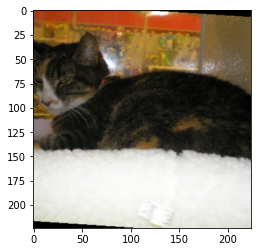

In [13]:
import matplotlib.pyplot as plt
import numpy as np

# Run random image through model
inverse_normalize = transforms.Normalize(
    mean=[-0.485/0.229, -0.456/0.224, -0.406/0.225],
    std = [1/0.229, 1/0.224, 1/0.225]
)

ix = 628
im = inverse_normalize(test_data[ix][0])
plt.imshow(np.transpose(im.numpy(), (1,2,0)))

In [18]:
AlexNetModel.eval()

with torch.no_grad():
    new_pred = AlexNetModel(test_data[ix][0].view(1,3,224,224)).argmax()

train_data.classes[new_pred.item()]
# The model correctly predicts a cat!

'Cat'